<a href="https://colab.research.google.com/github/nyoons/ESAA/blob/main/Part_03_%EC%BC%80%EB%9D%BC%EC%8A%A4_%EA%B3%BC%EC%A0%9C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**04. 모델 세부 설정**
데이터 정규화까지 처리하여 입력 데이터를 준비하자.

In [1]:
import tensorflow as tf

#케라스의 내장 데이터셋에서 mnist 데이터 로드
mnist=tf.keras.datasets.mnist

#load_data()로 데이터 로드
(x_train, y_train), (x_test, y_test)=mnist.load_data()

#로드된 데이터셋 확인
print('train set:', x_train.shape, y_train.shape)
print('test set:', x_test.shape, y_test.shape)

#데이터 정규화
x_train=x_train/x_train.max()
x_test=x_test/x_test.max()

11490434/11490434 [==============================] - 0s 0us/step
train set: (60000, 28, 28) (60000,)
test set: (10000, 28, 28) (10000,)


###**4-1. 초기값 설정**
레이어의 초기화 방법을 다르게 설정할 수 있다. dense 레이어는 기본 초기화 방법으로 Glorot Uniform 방법 사용.

In [2]:
dense=tf.keras.layers.Dense(256, activation='relu')
dense.get_config()['kernel_initializer']

{'class_name': 'GlorotUniform', 'config': {'seed': None}}

변경해보자.

In [3]:
#문자열 초기화
dense=tf.keras.layers.Dense(256, kernel_initializer='he_normal', activation='relu')
print(dense.get_config()['kernel_initializer'])

#클래스 인스턴스 초기화
he_normal=tf.keras.initializers.HeNormal()
dense=tf.keras.layers.Dense(256, kernel_initializer=he_normal, activation='relu')
print(dense.get_config()['kernel_initializer'])

{'class_name': 'HeNormal', 'config': {'seed': None}}
{'class_name': 'HeNormal', 'config': {'seed': None}}


케라스에서 지원하는 자주 사용되는 초기화 목록
- glorot_normal / uniform
- lecun_normal / uniform
- he_normal / uniform
- random_normal / uniform 등

###**4-2. 규제**
L1, L2 규제를 적용하기도 함.

In [4]:
#기본값
dense=tf.keras.layers.Dense(256, activation='relu')
dense.get_config()

{'name': 'dense_3',
 'trainable': True,
 'dtype': 'float32',
 'units': 256,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [5]:
#L1 규제 적용
dense=tf.keras.layers.Dense(256, kernel_regularizer='l1', activation='relu')
print(dense.get_config()['kernel_regularizer'])

#클래스 인스턴스 적용, alpha=0.1 변경
regularizer=tf.keras.regularizers.l1(l1=0.1)
dense=tf.keras.layers.Dense(256, kernel_regularizer=regularizer, activation='relu')
print(dense.get_config()['kernel_regularizer'])

{'class_name': 'L1', 'config': {'l1': 0.009999999776482582}}
{'class_name': 'L1', 'config': {'l1': 0.10000000149011612}}


###**4-3. 드롭아웃**
딥러닝의 난제 과대적합. 딥러닝 모델의 층이 넓고 깊어질 때 모델은 훈련에 주어진 샘플에 과하게 적합하도록 학습하는 경향이 있다. 드롭아웃은 과대적합 문제를 해결하기 위해 제안된 아이디어.

노드의 일부 신호를 임의로 삭제하면 모델이 쉽게 과대적합되는 것을 막을 수 있다. 모델이 학습하는 가중치 파라미터의 개수가 현저히 줄기 때문.

모델이 훈련할 때는 드롭아웃이 적용되어 노드 중 일부만 학습하지만, 예측 시점에는 모든 노드들이 활용된다.

In [6]:
#dropout 25% 비율 적용 (25% 노드가 삭제)
tf.keras.layers.Dropout(0.25)

###**4-4. 배치 정규화**
배치 정규화는 각 층에서 활성화 함수를 통과하기 전 미니 배치의 스케일을 정규화한다. 다음 층으로 전달되기 전에 데이터의 스케일을 조정하기 때문에 안정적.

케라스에서 클래스 함수로 지원한다.

In [7]:
#model A: Dense+ReLu
model_a=tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model_a.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                50240     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 10)                330       
                                                                 
Total params: 52,650
Trainable params: 52,650
Non-trainable params: 0
_________________________________________________________________


In [8]:
#model B: Dense+BatchNorm+ReLU
model_b=tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64),
    #여기서 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    #배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(32),
    #배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    #배치 정규화 후 활성화 함수 적용
    tf.keras.layers.Activation('relu'),

    tf.keras.layers.Dense(10, activation='softmax')
])

model_b.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                      

배치 정규화만 추가해도 손실은 이전 대비 더 안정적이고 빠르게 수렴할 수 있다.

###**4-5. 활성화 함수**
지금까지 주로 dense 레이어에 ReLu 활성화 함수를 사용. 다른 활성화 함수를 지정할 수 있다.

In [9]:
#LeakyReLU 기본 설정
tf.keras.layers.LeakyReLU()

#LeakyReLU, alpha=0.2로 변경
tf.keras.layers.LeakyReLU(alpha=0.2)

In [10]:
#model C: Dense+BatchNorm+LeakyReLU(0,2)
model_c=tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(64),
    #여기서 배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    #배치 정규화 후 활성화 함수 (LeakyReLU, alpha=0.2) 적용
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Dense(32),
    #배치 정규화 적용
    tf.keras.layers.BatchNormalization(),
    #배치 정규화 후 활성화 함수 적용
    tf.keras.layers.LeakyReLU(alpha=0.2),

    tf.keras.layers.Dense(10, activation='softmax')
])

model_c.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 64)                50240     
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_3 (Batc  (None, 32)               128       
 hNormalization)                                      

model a, b, c를 훈련한 후 수렴 속도를 비교해보자.

In [11]:
model_a.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_b.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_c.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Model A : Dense + ReLU
history_a=model_a.fit(x_train, y_train,
                      validation_data=(x_test, y_test), epochs=10)
#Model B : Dense + BatchNorm + ReLU
history_b=model_b.fit(x_train, y_train,
                      validation_data=(x_test, y_test), epochs=10)
#Model C : Dense + BatchNorm + LeakyReLU(0,2)
history_c=model_c.fit(x_train, y_train,
                      validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 16s 7ms/step - loss: 0.2882 - accuracy: 0.9160 - val_loss: 0.1744 - val_accuracy: 0.9465
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1341 - accuracy: 0.9606 - val_loss: 0.1108 - val_accuracy: 0.9667
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0991 - accuracy: 0.9699 - val_loss: 0.1010 - val_accuracy: 0.9693
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0804 - accuracy: 0.9755 - val_loss: 0.0950 - val_accuracy: 0.9701
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0653 - accuracy: 0.9796 - val_loss: 0.1061 - val_accuracy: 0.9683
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0561 - accuracy: 0.9826 - val_loss: 0.0932 - val_accuracy: 0.9738
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0500 - accuracy: 0.9843 - val_loss: 0.0923 - val_accurac

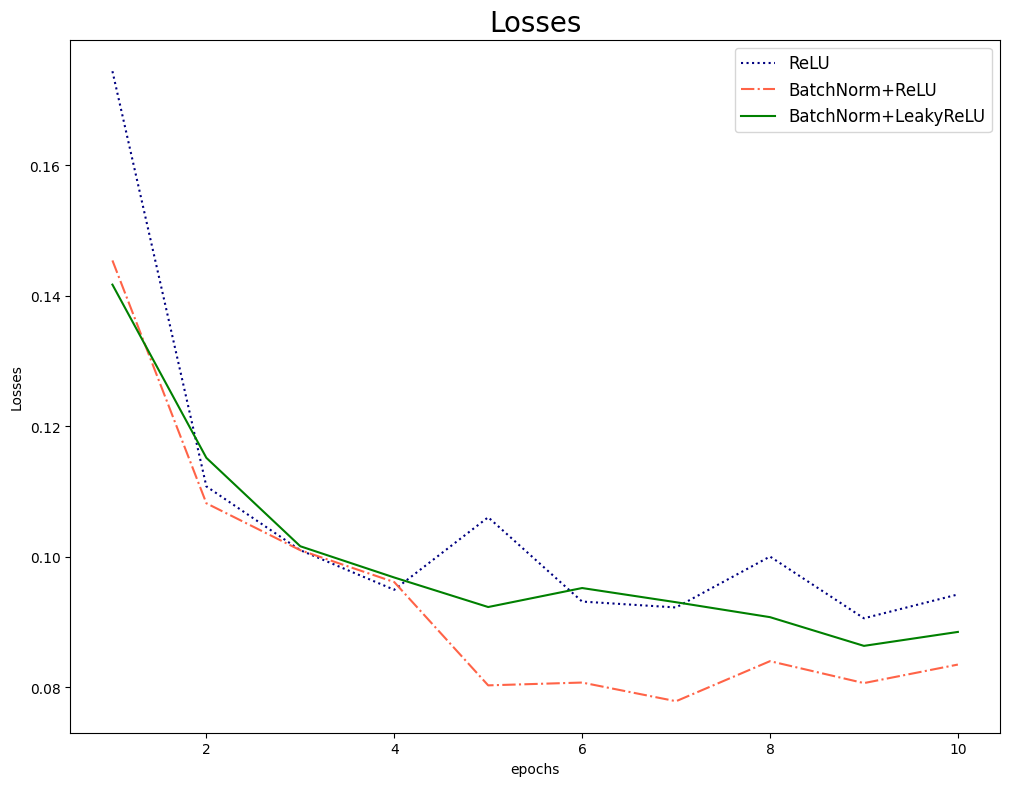

In [12]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, 11), history_a.history['val_loss'], color='navy', linestyle=':')
plt.plot(np.arange(1, 11), history_b.history['val_loss'], color='tomato', linestyle='-.')
plt.plot(np.arange(1, 11), history_c.history['val_loss'], color='green', linestyle='-')

plt.title('Losses', fontsize=20)
plt.xlabel('epochs')
plt.ylabel('Losses')
plt.legend(['ReLU', 'BatchNorm+ReLU', 'BatchNorm+LeakyReLU'], fontsize=12)
plt.show()

mnist는 모델별 차이가 크진 않지만 좀 더 복잡한 데이터에서는 차이가 있다.

##**06. 모델 저장 및 불러오기**
model_b를 저장해보자.

###**6-1. 모델을 파일로 저장**
훈련을 종료해 가중치가 업데이트 된 모델 인스턴스를 저장할 수 있다. save() 메소드 사용. 모델을 저장하는 형식은 HDF5 포맷과 SaverModel 포맷 두가지.

파일명이 .h5 확장자면 HDF5 포맷으로 저장한다. 대용량 데이터.

In [14]:
#모델명을 h5 포맷으로 저장
model_b.save('h5-model.h5')

###**6-2. 저장된 모델 복원**
tensorflow.kerase.models.load_model() 메서드를 이용하면 모델을 복원할 수 있다.

In [15]:
#모델 복원
h5_model=tf.keras.models.load_model('h5-model.h5')
h5_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                      

summary로 불러와보면 그대로 복원되어 있다.

모델을 검증해 복원이 잘 되었는지 확인하자. 검증 셋을 evaluate 함수에 대입해 손실 함수와 평가 지표를 계산

In [16]:
#모델 검증
loss, acc=h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5_model] loss: {loss:.5f}, acc: {acc:.5f}')

h5_model] loss: 0.08351, acc: 0.97640


.h5 확장자를 생략하면 SavedModel 포맷으로 저장된다. 복원은 같은 방식으로 하면 된다.

In [17]:
#모델을 SavedModel 포맷으로 저장
model_b.save('saved-model')

In [18]:
#모델 복원
saved_model=tf.keras.models.load_model('saved-model')
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                      

h5와 동일한 성능이 나타난다.

In [19]:
#모델 검증 (HDF5 포맷)
loss, acc=h5_model.evaluate(x_test, y_test, verbose=0)
print(f'h5_model] loss: {loss:.5f}, acc: {acc:.5f}')

#모델 검증 (SavedModel 포맷)
loss, acc=saved_model.evaluate(x_test, y_test, verbose= 0)
print(f'saved_model] loss: {loss:.5f}, acc: {acc:.5f}')

h5_model] loss: 0.08351, acc: 0.97640
saved_model] loss: 0.08351, acc: 0.97640


##**07. 복잡한 모델 생성**

###**7-1. 함수형 API**
함수 형태로 딥러닝 모델을 정의하면 다양한 모델 구조 구현 가능. 따라서 sequential과 다르게 복잡한 구조의 모델을 정의할 수 있다. 함수의 입력 매개변수를 여러 개 갖는 다중 입력, 함수의 return 값을 여러개 갖는 다중 출력, 같은 레벨에 여러 층을 배치해 입력과 출력을 공유하는 구조도 가능.

Sequential은 단방향만 가능했음. (데이터 흐름이 특정 레이어를 건너뛰거나, 병합 및 분리하는 구조를 구현할 수 없음).

함수형은 먼저 input 레이어를 정의해야한다. input 레이어에 데이터의 입력 shape 정의. 레이어마다 반환되는 출력 값을 변수에 저장한 뒤 다음 레이어의 입력으로 연결한다. 이렇게 여러 개의 레이어를 마치 체인 구조로 입출력을 계속 연결할 수 있다.

In [20]:
import tensorflow as tf

#모델의 레이어를 체인 구조로 연결 input 레이어 정의
input_layer=tf.keras.Input(shape=(28, 28), name='InputLayer')

#모델의 레이어를 체인 구조로 연결
x1=tf.keras.layers.Flatten(name='Flatten')(input_layer)
x2=tf.keras.layers.Dense(256, activation='relu', name='Dense1')(x1)
x3=tf.keras.layers.Dense(64, activation='relu', name='Dense2')(x2)
x4=tf.keras.layers.Dense(10, activation='softmax', name='OutputLayer')(x3)

레이어마다 name 매개변수로 이름을 부여할 수 있다. 이렇게 체인 방식으로 연결한 후 tf.keras.Model() 에 입력 레이어와 출력 레이어를 정의해 모델을 생성한다.

In [21]:
#모델 생성
func_model=tf.keras.Model(inputs=input_layer, outputs=x4, name='FunctionalModel')

#모델 요약
func_model.summary()

Model: "FunctionalModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28)]          0         
                                                                 
 Flatten (Flatten)           (None, 784)               0         
                                                                 
 Dense1 (Dense)              (None, 256)               200960    
                                                                 
 Dense2 (Dense)              (None, 64)                16448     
                                                                 
 OutputLayer (Dense)         (None, 10)                650       
                                                                 
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


input, ouputs 레이어 지정.

지금까지 summary()로 모델의 요약을 확인함. 하지만 복잡한 구조는 summary()로 모델의 구조도를 보기가 어렵다. plot_model 모듈 활용해보자.

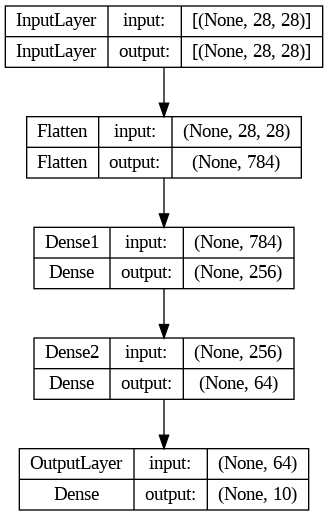

In [22]:
from tensorflow.keras.utils import plot_model

#구조도 시각화
plot_model(func_model, show_shapes=True, show_layer_names=True, to_file='model.png')

함수형 API로 생성한 모델도 sequential API와 동일한 방식으로 훈련할 수 있다.

In [23]:
#컴파일
func_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#훈련
func_model.fit(x_train, y_train, epochs=3)

#검증
loss, acc=func_model.evaluate(x_test, y_test, verbose=0)
print(f'Functional Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2093 - accuracy: 0.9379
Epoch 2/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0872 - accuracy: 0.9729
Epoch 3/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0601 - accuracy: 0.9807
Functional Model] loss: 0.07550, acc: 0.97550


###**7-2. 모델 서브클래싱**
Model 클래스를 상속받아 사용자가 직접 서브클래스로 딥러닝 모델을 만들 수 있다. 그러나 함수형 API로 생성한 모델과의 성능 차이는 없다.

Model Subclassing으로 모델 인스턴스를 생성하기 위해서는 tf.keras.Model을 상속받아 생성하고자 하는 모델 클래스를 구현하면 된다.

In [24]:
class MyModel(tf.keras.Model):
  def __init__(self):
    super(MyModel, self).__init__()
    #초기값 설정
    self.flatten=tf.keras.layers.Flatten()
    self.dense1=tf.keras.layers.Dense(256, activation='relu')
    self.dense2=tf.keras.layers.Dense(64, activation='relu')
    self.dense3=tf.keras.layers.Dense(10, activation='softmax')

  #method overiding
  #훈련용 함수 정의
  #x는 input
  def call(self, x):
    x=self.flatten(x)
    x=self.dense1(x)
    x=self.dense2(x)
    x=self.dense3(x)
    return x


call()은 fit 메서드가 호출되어 훈련하는 경우 호출될 함수.

In [25]:
#모델 생성
mymodel=MyModel()

#모델의 이름 설정
mymodel._name='subclass_model'

#모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28, 28)))

#모델 요약
mymodel.summary()

Model: "subclass_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_15 (Dense)            multiple                  200960    
                                                                 
 dense_16 (Dense)            multiple                  16448     
                                                                 
 dense_17 (Dense)            multiple                  650       
                                                                 
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


input에 shape을 정의해야 모델의 요약을 확인할 수 있다.

In [26]:
#컴파일
mymodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#훈련
mymodel.fit(x_train, y_train, epochs=3)

#검증
loss, acc=mymodel.evaluate(x_test, y_test, verbose=0)
print(f'Subclassing Model] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2125 - accuracy: 0.9368
Epoch 2/3
1875/1875 [==============================] - 10s 6ms/step - loss: 0.0887 - accuracy: 0.9719
Epoch 3/3
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0604 - accuracy: 0.9809
Subclassing Model] loss: 0.06805, acc: 0.97800


동일하게 compile, fit 등 적용 가능. 모델을 생성하는 방식에 차이가 있을 뿐이다.

###**7-3. 서브클래싱 모델 파라미터를 활용한 생성**
Model subclassing의 장점은 생성자 파라미터로 모델 내부 레이어의 하이퍼 파라미터를 지정할 수 있다는 것.

모델의 생성자 파라미터를 추가해 동적으로 레이어의 유닛 개수를 초기화하는 예제를 보자.

In [27]:
class MyModel(tf.keras.Model):

  #생성자 파라미터 추가
  def __init__(self, units, num_classes):
    super(MyModel, self).__init__()
    #초기값 설정
    self.flatten=tf.keras.layers.Flatten()
    self.dense1=tf.keras.layers.Dense(units, activation='relu')
    self.dense2=tf.keras.layers.Dense(units/4, activation='relu')
    self.dense3=tf.keras.layers.Dense(num_classes, activation='softmax')

  #class overiding
  #훈련용 함수 정의
  #x는 input
  def call(self, x):
    x=self.flatten(x)
    x=self.dense1(x)
    x=self.dense2(x)
    x=self.dense3(x)
    return x

모델의 생성자 파라미터로 기준이 되는 unit의 개수를 입력받아 dense 레이어의 유닛 개수를 계산하여 설정한다.

In [28]:
#모델 생성
mymodel=MyModel(256, 10)

#모델 input 정의
mymodel(tf.keras.layers.Input(shape=(28, 28)))

#모델 요약
mymodel.summary()

Model: "my_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         multiple                  0         
                                                                 
 dense_18 (Dense)            multiple                  200960    
                                                                 
 dense_19 (Dense)            multiple                  16448     
                                                                 
 dense_20 (Dense)            multiple                  650       
                                                                 
Total params: 218,058
Trainable params: 218,058
Non-trainable params: 0
_________________________________________________________________


조건문, 반복문 추가해 더 동적인 모델을 생성할수도 있다. summary 결과를 보면 동적으로 설정한 레이어의 파라미터가 초기화 되었음을 알 수 있다.

In [29]:
#컴파일
mymodel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#훈련
mymodel.fit(x_train, y_train, epochs=3)

#검증
loss, acc=mymodel.evaluate(x_test, y_test, verbose=0)
print(f'Subclassing Model w.parameters] loss: {loss:.5f}, acc: {acc:.5f}')

Epoch 1/3
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2150 - accuracy: 0.9366
Epoch 2/3
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0900 - accuracy: 0.9726
Epoch 3/3
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0613 - accuracy: 0.9811
Subclassing Model w.parameters] loss: 0.07281, acc: 0.97600


역시 동일한 방식으로 컴파일, 훈련, evaluate 할 수 있다.